# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, plot_confusion_matrix

sys.path.append("..")
from helpers import tridata

Welcome to JupyROOT 6.16/00


In [2]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(
                train[train[label] == h]["nHits"],
                range=(0, 500),
                bins=500,
                density=True,
            )[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(
                train[train[label] == h]["nClus"],
                range=(0, 500),
                bins=500,
                density=True,
            )[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(
                train[train[label] == h]["Edep"],
                range=(0, 5000),
                bins=500,
                density=True,
            )[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [self._hits[h][x["nHits"]] * self._clus[h][x["nClus"]] * self._edep[h][x["Edep"].floordiv(10).astype(int)] for h in self._hypos]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [3]:
nmax = 4
traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=nmax, physics="inclxx")

# traindata.loc[traindata["nHits"] == 0, "nPN"] = 0
# testdata.loc[testdata["nHits"] == 0, "nPN"] = 0
display(traindata["nPN"].value_counts())
display(testdata["nPN"].value_counts())

2    160225
1    160050
4    159980
3    159970
0         2
Name: nPN, dtype: int64

3    40030
4    40020
1    39948
2    39775
Name: nPN, dtype: int64

## Example Fit / Calibration & Prediction

In [4]:
model = Bayes(traindata, nmax, "nPN")
y_pred = model.predict(testdata)
y_true = testdata["nPN"].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(2, 2), (1, 1), (3, 2), (3, 4), (1, 1), (1, 1), (4, 3), (3, 3), (2, 3), (3, 2), (3, 3), (3, 3), (2, 1), (1, 1), (4, 3), (1, 1), (2, 2), (3, 3), (1, 1), (2, 3), (4, 3), (1, 1), (4, 4), (4, 4), (2, 2), (3, 4), (2, 1), (4, 3), (1, 1), (1, 1), (4, 4), (2, 1), (2, 2), (1, 1), (3, 3), (4, 4), (1, 1), (4, 4), (4, 3), (3, 2), (4, 4), (2, 2), (3, 3), (2, 2), (4, 3), (2, 1), (2, 3), (2, 2), (2, 2), (4, 4)]


In [5]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print((cmrel * 100).round())

0.6644997816197242


/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


[[    0     0     0     0     0]
 [ 1925 33502  4491    22     8]
 [   89  7846 24142  7484   214]
 [   10  1164  9096 19868  9892]
 [    4   143  1872  9344 28657]]
[[ 0.  0.  0.  0.  0.]
 [ 5. 84. 11.  0.  0.]
 [ 0. 20. 61. 19.  1.]
 [ 0.  3. 23. 50. 25.]
 [ 0.  0.  5. 23. 72.]]


Text(69.0, 0.5, 'True')

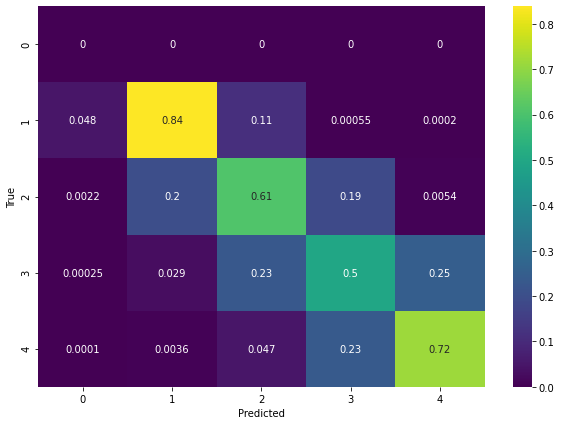

In [6]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

## Evaluation for different max multiplicities

In [9]:
for dp in [30]:  # , 12]:
    for n in [2, 3, 4, 5]:
        for label in ["nPN", "nPH"]:
            traindata, testdata = tridata(distance=15, doubleplane=dp, energy=600, erel=500, nmax=n, physics="inclxx")

#             traindata.loc[traindata["nHits"] == 0, "nPN"] = 0
#             testdata.loc[testdata["nHits"] == 0, "nPN"] = 0
            
            model = Bayes(traindata, n, label)
            y_pred = model.predict(testdata)
            y_true = testdata[label].values.ravel()
            
            bac = balanced_accuracy_score(y_true, y_pred)
            cm = (confusion_matrix(y_true, y_pred, labels=range(0, n + 1), normalize="true") * 100).round()
            cmn = confusion_matrix(y_true, y_pred, labels=range(0, n + 1))
            print(dp, n, label, bac)
            print(cm)
            print(cmn)
            unique, counts = np.unique(y_true, return_counts=True)
            print(dict(zip(unique, counts)))
            print("\n")

30 2 nPN 0.8796254531482317
[[100.   0.   0.]
 [  5.  84.  12.]
 [  0.  19.  80.]]
[[    1     0     0]
 [ 1947 33330  4629]
 [   91  7744 32071]]
{0: 1, 1: 39906, 2: 39906}


30 2 nPH 0.9228338115840561
[[100.   0.   0.]
 [  0.  91.   9.]
 [  0.  14.  86.]]
[[ 2069     3     2]
 [    3 38319  3815]
 [    6  5000 31144]]
{0: 2074, 1: 42137, 2: 36150}




/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


30 3 nPN 0.7276265980179693
[[ 0.  0.  0.  0.]
 [ 5. 84. 11.  0.]
 [ 0. 20. 60. 20.]
 [ 0.  3. 23. 74.]]
[[    0     0     0     0]
 [ 1981 33468  4577    43]
 [   91  7917 24144  7913]
 [   10  1172  9005 29762]]
{1: 40069, 2: 40065, 3: 39949}


30 3 nPH 0.8504871715619324
[[100.   0.   0.   0.]
 [  0.  91.   9.   0.]
 [  0.  14.  69.  17.]
 [  0.   1.  19.  80.]]
[[ 2064     5     1     0]
 [    2 38114  3827    28]
 [    2  5725 28842  7021]
 [    4   259  6472 27498]]
{0: 2070, 1: 41971, 2: 41590, 3: 34233}


30 4 nPN 0.7284968957380389
[[100.   0.   0.   0.   0.]
 [  5.  84.  11.   0.   0.]
 [  0.  20.  60.  19.   1.]
 [  0.   3.  23.  49.  25.]
 [  0.   0.   5.  24.  71.]]
[[    1     0     0     0     0]
 [ 1989 33380  4557    36    12]
 [   95  7907 24013  7551   231]
 [    6  1245  9144 19983 10018]
 [    4   150  1906  9417 28014]]
{0: 1, 1: 39974, 2: 39797, 3: 40396, 4: 39491}


30 4 nPH 0.7888874149536631
[[100.   0.   0.   0.   0.]
 [  0.  91.   9.   0.   0.]
 [  0.  14.  

/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


30 5 nPN 0.6112385843439802
[[ 0.  0.  0.  0.  0.  0.]
 [ 5. 84. 11.  0.  0.  0.]
 [ 0. 20. 60. 19.  0.  0.]
 [ 0.  3. 23. 50. 23.  2.]
 [ 0.  0.  5. 24. 43. 28.]
 [ 0.  0.  1.  7. 24. 69.]]
[[    0     0     0     0     0     0]
 [ 1944 33496  4598    33     4     4]
 [   99  7772 23912  7696   185    15]
 [    6  1110  9192 19915  9252   695]
 [    0   131  1888  9456 17267 11044]
 [    4    15   278  2613  9597 27585]]
{1: 40079, 2: 39679, 3: 40170, 4: 39786, 5: 40092}


30 5 nPH 0.7365082030502058
[[100.   0.   0.   0.   0.   0.]
 [  0.  91.   9.   0.   0.   0.]
 [  0.  14.  69.  17.   0.   0.]
 [  0.   1.  19.  58.  21.   1.]
 [  0.   0.   2.  22.  51.  25.]
 [  0.   0.   0.   3.  24.  73.]]
[[ 2085     2     2     0     0     1]
 [    0 38176  3857    22     7     1]
 [    1  5703 29151  7100   108     5]
 [    0   310  8068 24542  8728   413]
 [    0    12   805  8841 20471 10141]
 [    2     0    32  1029  7358 22661]]
{0: 2090, 1: 42063, 2: 42068, 3: 42061, 4: 40270, 5: 31082}